In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Retrived calculated expected returns and ADs
all_dfs = {}
all_keys_list = pd.read_csv('Data/all_keys_df.csv')['key'].values.tolist()

for key in all_keys_list:
    all_dfs[key] = pd.read_csv(f"Data/{key}.csv")
    all_dfs[key]['Date'] = pd.to_datetime(all_dfs[key]['Date'])
    all_dfs[key].set_index('Date',inplace = True)

In [3]:
monthly_returns_df = pd.read_csv('Data/monthly_return.csv')
monthly_returns_df = monthly_returns_df.drop(columns=['Date'])
asset_returns = monthly_returns_df.values

In [4]:
def equal_weighted_strategy(asset_returns):
    """
    Create an equally weighted investment portfolio and plot its performance.

    Parameters:
        *return_arrays: Variable number of arrays representing returns of individual assets.

    Returns:
        A matplotlib graph showing the portfolio performance.
    """
    weights = 0.1  
    portfolio_returns = np.sum(asset_returns * weights, axis=1)

    # Plot the portfolio performance
    plt.figure(figsize=(8, 6))
    plt.plot(portfolio_returns, label='Equally Weighted Portfolio', linewidth=2)
    plt.title('Equally Weighted Portfolio Return', fontsize=14)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Portfolio Returns', fontsize=12)
    plt.grid(alpha=0.5)
    plt.legend()
    plt.show()

    return portfolio_returns

In [5]:
def mean_variance_strategy(monthly_returns_df, window_size=24):
    """
    Create a mean-variance optimized investment portfolio with rolling window covariance matrix and plot its performance.

    Parameters:
        *return_arrays: Variable number of arrays representing returns of individual assets.
        window_size (int): Rolling window size for calculating covariance matrix (default: 24 for 2 years of monthly returns).

    Returns:
        A matplotlib graph showing the portfolio performance.
    """

    # Initialize variables for cumulative returns
    portfolio_returns = [1.0]

    # Rolling window optimization
    for start in range(len(monthly_returns_df) - window_size):
        # Select the rolling window data
        rolling_data = monthly_returns_df.iloc[start:start + window_size]

        # Calculate mean and covariance of returns within the window
        mean_returns = rolling_data.mean()
        cov_matrix = rolling_data.cov()

        # Number of assets
        num_assets = 10

        # Calculate weights for the mean-variance optimization (minimizing variance)
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        ones = np.ones(num_assets)
        weights = inv_cov_matrix @ ones / (ones @ inv_cov_matrix @ ones)

        # Calculate portfolio return for the next period
        next_return = monthly_returns_df.iloc[start + window_size].dot(weights)
        portfolio_returns.append(next_return)
        # Update cumulative returns

    # Plot the portfolio performance
    plt.figure(figsize=(8, 6))
    plt.plot(portfolio_returns, label='Mean-Variance Optimized Portfolio', linewidth=2)
    plt.title('Mean-Variance Portfolio Return', fontsize=14)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Portfolio Returns', fontsize=12)
    plt.grid(alpha=0.5)
    plt.legend()
    plt.show()

    return portfolio_returns

In [6]:
def multibangbang_strategy(expected_returns, asset_returns):
    """
    Implements the multi-bang-bang investment strategy.

    Parameters:
        expected_returns (numpy.ndarray): A 2D array where each row corresponds to the expected returns at time t for N risky assets.
        asset_returns (numpy.ndarray): A 2D array where each row corresponds to the actual returns of N risky assets at time t.

    Returns:
        numpy.ndarray: Portfolio cumulative performance over time.
    """
    # Initialize variables
    num_periods = 107
    num_assets = 10
    portfolio_return = [] 

    # Loop through each time period
    for t in range(num_periods):
        # Find the asset with the highest positive expected return
        mt = expected_returns.iloc[t]
        imax = np.argmax(mt)
        # print(imax)

        # Initialize weights for risky assets
        weights = np.zeros(num_assets)

        if mt[imax] > 0:
            weights[imax] = 1  # Invest all in the asset with the highest positive return
        # Else, all weights remain 0 (fully invested in cash, implicitly)

        # Calculate the portfolio return for the period
        portfolio_return.append(np.sum(weights * asset_returns.iloc[t]))

        # Update cumulative performance
        # portfolio_performance.append(portfolio_performance[-1] * (1 + portfolio_return))

    # Plot the portfolio performance
    plt.figure(figsize=(8, 6))
    plt.plot(portfolio_return, label='Multi-Bang-Bang Strategy', linewidth=2)
    plt.title('Multi-Bang-Bang Strategy Return', fontsize=14)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Portfolio Returns', fontsize=12)
    plt.grid(alpha=0.5)
    plt.legend()
    plt.show()

    return portfolio_return

## Data Preparing

In [7]:
# Select relevant columns from monthly_returns_df
monthly = monthly_returns_df[['USE', 'USSC', 'UST', 'LTB', 'USR', 'GC', 'BC', 'TSE', 'USB', 'BB']].iloc[-107:]

# Create a dictionary for merged SMSV DataFrames
SMSV_EMA = {f'EMA{i}': pd.merge(all_dfs[f'SMSV_EMA{i}_df'], all_dfs['CMSV_df'], on='Date') for i in range(1, 10)}
SMSV_EMASO = pd.merge(all_dfs['SMSV_EMASO_df'], all_dfs['CMSV_df'], on='Date')

# Create dictionaries for AD_1, AD_2, and AD_3
def create_ad_dict(df, suffix):
    return {f'EMA{i}': df[[f'USE_SMSV_EMA{i}_{suffix}', f'USSC_SMSV_EMA{i}_{suffix}', f'UST_SMSV_EMA{i}_{suffix}',
                          f'LTB_SMSV_EMA{i}_{suffix}', f'USR_SMSV_EMA{i}_{suffix}', f'GC_SMSV_EMA{i}_{suffix}',
                          f'BC_SMSV_EMA{i}_{suffix}', f'TSE_SMSV_EMA{i}_{suffix}', 'USB_CMSV_' + suffix, 'BB_CMSV_' + suffix]]
            for i in range(1, 10)}

AD_1 = create_ad_dict(all_dfs['AD1_df'], 'AD1')
AD_2 = create_ad_dict(all_dfs['AD2_df'], 'AD2')
AD_3 = create_ad_dict(all_dfs['AD3_df'], 'AD3')

# Add EMASO to each AD dictionary
AD_1_EMASO = all_dfs['AD1_df'][['USE_SMSV_EMASO_AD1', 'USSC_SMSV_EMASO_AD1', 'UST_SMSV_EMASO_AD1', 'LTB_SMSV_EMASO_AD1',
                                    'USR_SMSV_EMASO_AD1', 'GC_SMSV_EMASO_AD1', 'BC_SMSV_EMASO_AD1', 'TSE_SMSV_EMASO_AD1',
                                    'USB_CMSV_AD1', 'BB_CMSV_AD1']]
AD_2_EMASO = all_dfs['AD2_df'][['USE_SMSV_EMASO_AD2', 'USSC_SMSV_EMASO_AD2', 'UST_SMSV_EMASO_AD2', 'LTB_SMSV_EMASO_AD2',
                                    'USR_SMSV_EMASO_AD2', 'GC_SMSV_EMASO_AD2', 'BC_SMSV_EMASO_AD2', 'TSE_SMSV_EMASO_AD2',
                                    'USB_CMSV_AD2', 'BB_CMSV_AD2']]
AD_3_EMASO = all_dfs['AD3_df'][['USE_SMSV_EMASO_AD3', 'USSC_SMSV_EMASO_AD3', 'UST_SMSV_EMASO_AD3', 'LTB_SMSV_EMASO_AD3',
                                    'USR_SMSV_EMASO_AD3', 'GC_SMSV_EMASO_AD3', 'BC_SMSV_EMASO_AD3', 'TSE_SMSV_EMASO_AD3',
                                    'USB_CMSV_AD3', 'BB_CMSV_AD3']]

In [8]:
# Function to align columns and multiply AD dictionaries with SMSV
def align_and_multiply(ad_dict, smsv_dict):
    for key in ad_dict.keys():
        ad_dict[key] = 1 - ad_dict[key]
        # Align columns
        ad_dict[key].columns = smsv_dict[key].columns
        # Element-wise multiplication
        ad_dict[key] = ad_dict[key] * smsv_dict[key] 
        # 0 to na for average calculation 
        ad_dict[key] = ad_dict[key].replace(0, np.nan)

# Align and multiply for AD_1, AD_2, and AD_3
align_and_multiply(AD_1, SMSV_EMA)
align_and_multiply(AD_2, SMSV_EMA)
align_and_multiply(AD_3, SMSV_EMA)

In [9]:
# List of AD_EMASO DataFrames
AD_EMASOs = [AD_1_EMASO, AD_2_EMASO, AD_3_EMASO]
SMSVEMASOs = []

# Simplify operations for all AD_EMASO DataFrames
for i, AD_EMASO in enumerate(AD_EMASOs, start=1):
    # Subtract from 1 and align columns
    AD_EMASO = 1 - AD_EMASO
    AD_EMASO.columns = SMSV_EMASO.columns
    
    # Multiply with SMSV_EMASO
    SMSVEMASO = SMSV_EMASO * AD_EMASO
    SMSVEMASOs.append(SMSVEMASO)
    
    # Dynamically assign the resulting DataFrame to a variable
    globals()[f'SMSVEMASO_AD{i}'] = SMSVEMASO

## Average for EMA1-9

In [10]:
# Function to clean column names in AD_1
def average(ad_dict):
    # Select EMA1 to EMA9
    ema_keys = [f'EMA{i}' for i in range(1, 10)]
    
    for key in ema_keys:
        # Rename columns to keep only the part before the first '_'
        ad_dict[key].columns = ad_dict[key].columns.str.split('_').str[0]
    mean_df = pd.concat([ad_dict[key] for key in ema_keys], axis=0).groupby(level=0).mean()
    
    return mean_df

In [11]:
mean_AD1 = average(AD_1)
mean_AD2 = average(AD_2)
mean_AD3 = average(AD_3)

/var/folders/96/qy4rp5xs53jg5bnrc23rsvl40000gn/T/ipykernel_47496/1850995901.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if mt[imax] > 0:


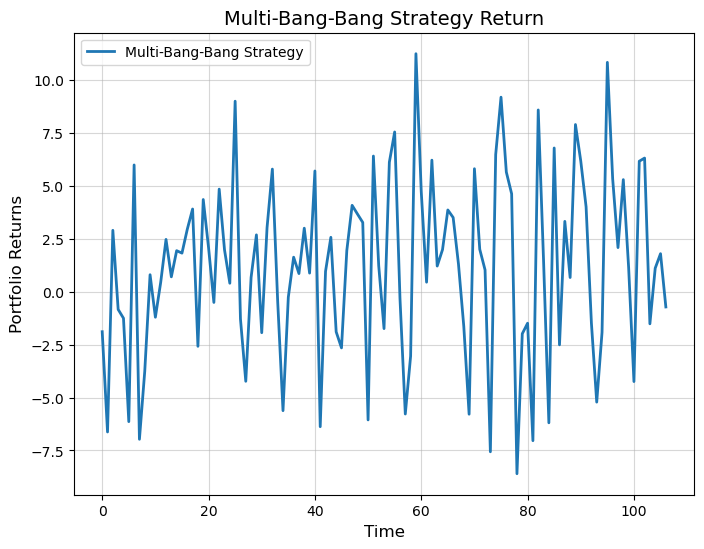

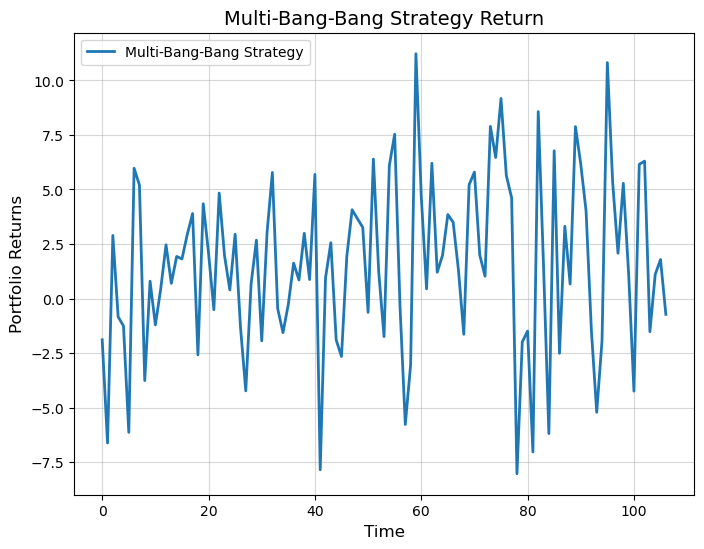

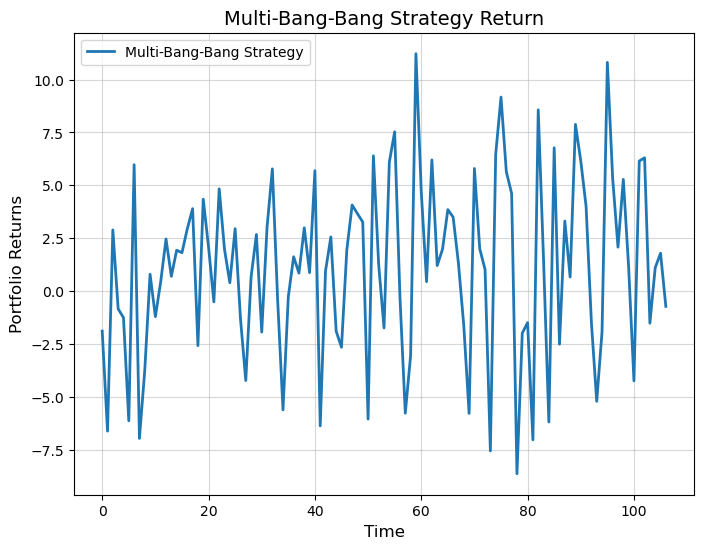

In [12]:
return_SMSVEMASO_AD1 = multibangbang_strategy(SMSVEMASO_AD1, monthly )
return_SMSVEMASO_AD2 = multibangbang_strategy(SMSVEMASO_AD2, monthly)
return_SMSVEMASO_AD3 = multibangbang_strategy(SMSVEMASO_AD3, monthly)

/var/folders/96/qy4rp5xs53jg5bnrc23rsvl40000gn/T/ipykernel_47496/1850995901.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if mt[imax] > 0:


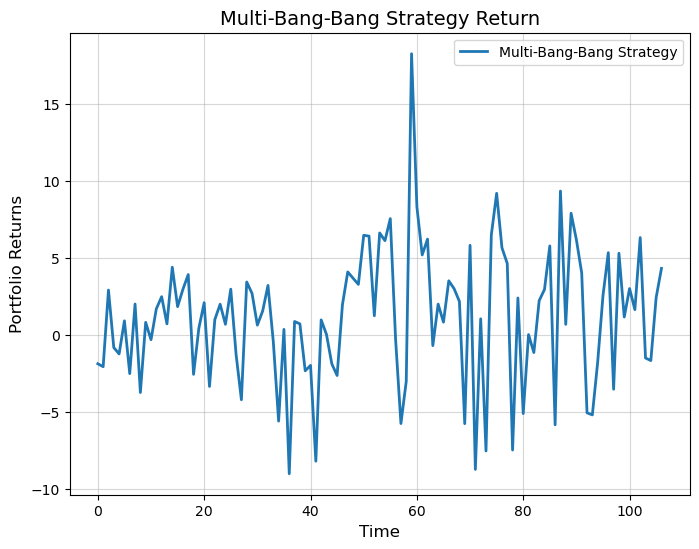

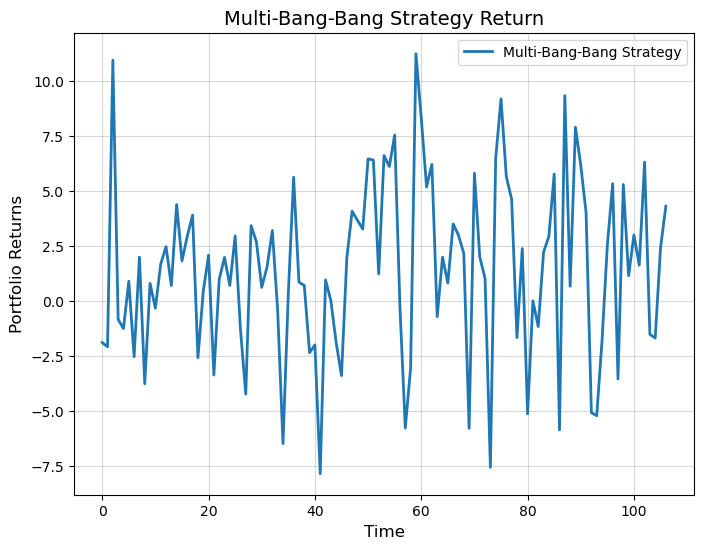

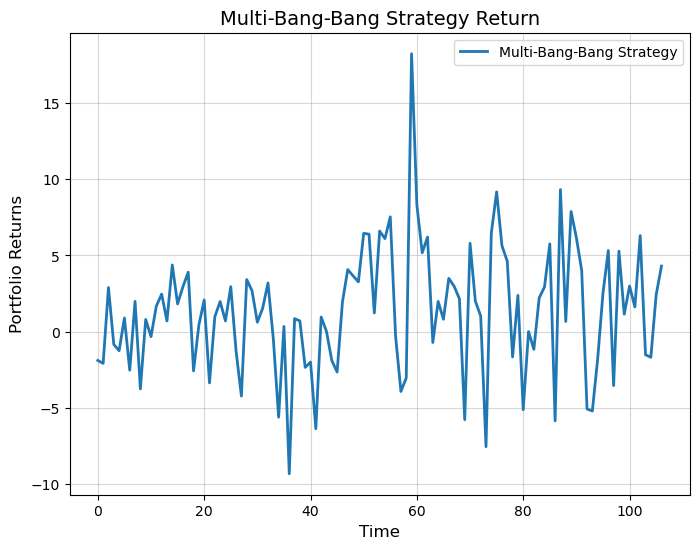

In [13]:
return_SMSVEMA_AD1 = multibangbang_strategy(mean_AD1, monthly)
return_SMSVEMA_AD2 = multibangbang_strategy(mean_AD2, monthly)
return_SMSVEMA_AD3 = multibangbang_strategy(mean_AD3, monthly)


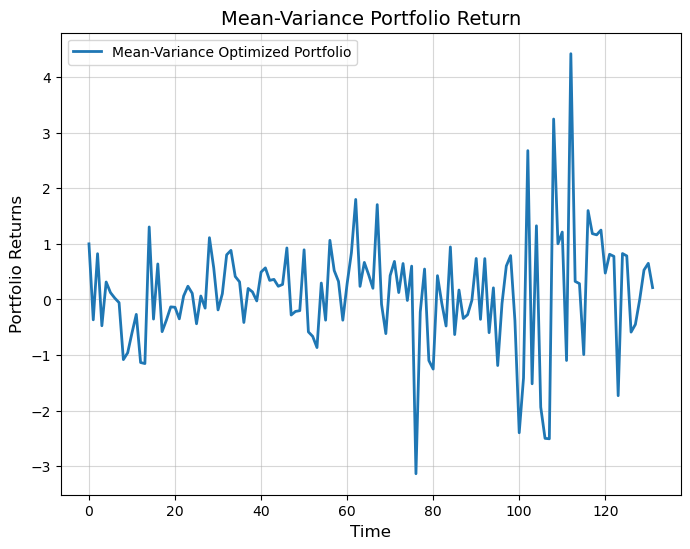

In [14]:
returns_MV = mean_variance_strategy(monthly_returns_df, window_size=24)
returns_MV = returns_MV[:107]

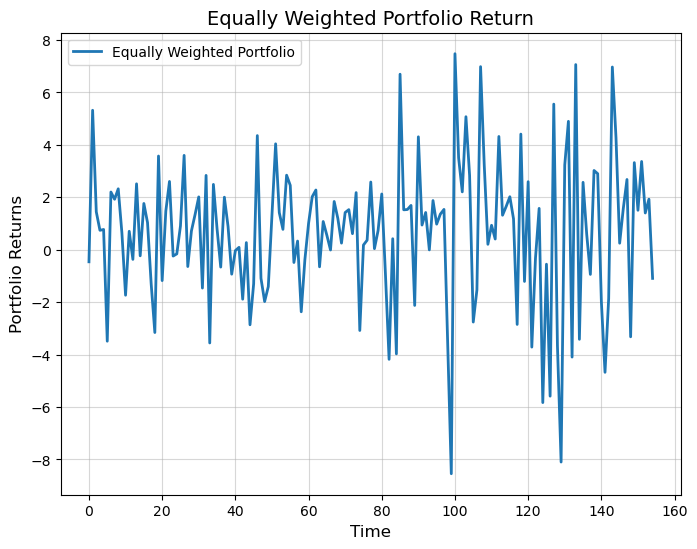

In [15]:
returns_EW = equal_weighted_strategy(asset_returns)
returns_EW = returns_EW[48:]

## Portfolio Value

In [16]:
def calculate_portfolio_value(returns, weights, transaction_cost_rate=0.001, initial_value=1):
    """
    Calculate portfolio value considering transaction costs.

    Parameters:
        returns (np.ndarray): A 2D array of shape (T, N) representing returns for N assets over T time steps.
        weights (np.ndarray): A 2D array of shape (T, N+1) representing portfolio weights (N risky assets + 1 cash) at each time step.
        transaction_cost_rate (float): Transaction cost rate (ci), default is 0.001 (10 bps or 0.1%).
        initial_value (float): Initial portfolio value V0, default is 1.

    Returns:
        np.ndarray: An array representing the portfolio value at each time step.
    """
    T, N = returns.shape
    portfolio_value = np.zeros(T + 1)
    portfolio_value[0] = initial_value  # Initial portfolio value

    for t in range(T):
        # Calculate transaction costs at time t
        if t == 0:
            previous_weights = np.zeros(N + 1)  # Initial weights are zero for all assets
        else:
            previous_weights = weights[t - 1]

        current_weights = weights[t]
        current_returns = returns[t]

        # Include cash (last column as 0 returns for cash)
        extended_returns = np.append(current_returns, 0)

        # Transaction cost: ci * |ω_t - ω_t-1 * V_t-1 * (1 + y_t)|
        transaction_costs = transaction_cost_rate * np.sum(
            np.abs(
                current_weights * portfolio_value[t]
                - previous_weights * portfolio_value[t] * (1 + extended_returns)
            )
        )

        # Update portfolio value: V_t+1 = V_t * (1 + ω_t' * y_t) - TC_t
        portfolio_value[t + 1] = (
            portfolio_value[t] * (1 + np.dot(current_weights, extended_returns))
            - transaction_costs
        )

    return portfolio_value[1:]  # Return portfolio values excluding the initial value